# **Linear Regression**

# **TOC**

## Introduction

### It is time to move into some really interesting stuff now (not to say that everyone doesn't love t-tests)- model building. We will be working through two types of models, linear and logistic regressions, but we will start here with linear.

### It is worth saying that most real world data is not linear, and, as such, in this notebook we will be trying to fit non linear data to a linear model. **This is not best practice**. We just wanted to provide you with multiple different examples on how to do a standard linear regression (we will end on the best one!).

### Lets do a bit of explaining before we dive in. First and foremost, what is a 'model' in data science In data science, a "model" is a mathematical representation of a system or process. It's constructed to predict outputs based on certain inputs, using patterns learned from past data. The pipeline for all model building is generally:

1. ### Training: We feed the model historical data where we know the input and the outcome. The model "learns" from this data, understanding patterns and relationships between the input and the outcome.

2. ### Testing: Once trained, we expose the model to a new set of data it hasn't seen before to evaluate its predictive capabilities. This helps ensure that the model isn't just memorizing the training data but is genuinely understanding underlying patterns.

3. ### Deployment: Once satisfied with its performance, we deploy the model in real-world scenarios. Here, it can make predictions or decisions based on new data it encounters.


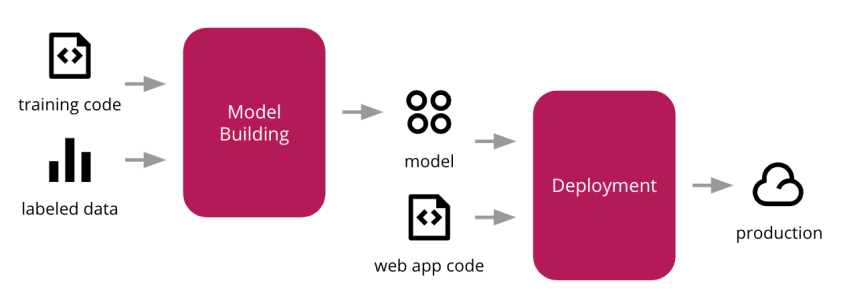

### Now lets talk about linear regressions. A linear regression models the relationship between a dependent variable and one or multiple independent variables. We are going to talk about some math, reallllllly quick. 

### When constructing a linear model, we are attempting to fit the data into the formula $\hat{Y}=X\theta$, where $\hat{Y}$ is the prediction vector, $X$ is the design matrix, and $\theta$ is the parameter vector. There are different approaches to create such models (or equations) mathematically. 

### The goal is to use the existing data $X$ and $Y$ data to generate the optimal $\theta$ used for later prediction.

### You can think of $\hat{Y}=X\theta$ as the classic $y = mx + b$ but now expanded to cover multiple $x$ (independent variables) and to make predictions $y$ (dependent variable) for multiple people at once.

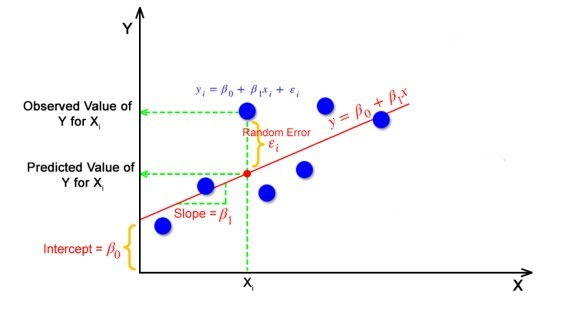

### If you understood that, great! If not, here is the layman summary. The whole point of a linear regression is to find the $y$ = $mx$ + $b$ formula that best fits your data. So based on the data you have, if you introduce a new $x$ data point can you predict what its $y$ value will be. In its most simple term, a linear regression is finding a ***line of best fit***. This is a much less scary way to think about this model, and if that is easier for you then you should do it!

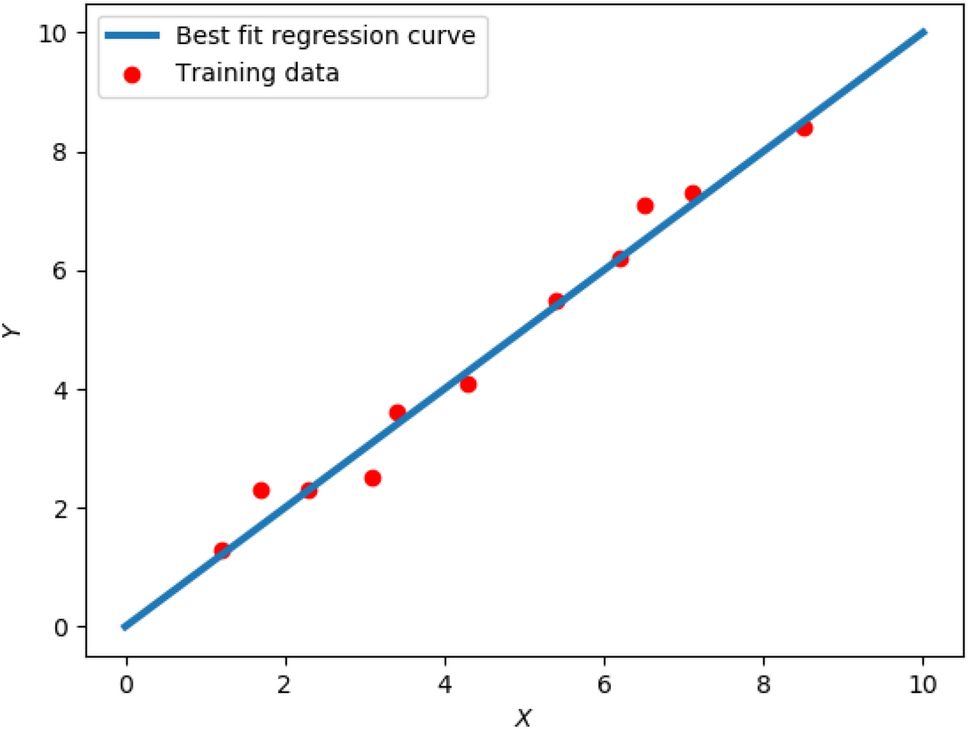


### To gauge how well a linear regression model performs, we consider several metrics:

1. ### R-squared Value: This metric tells us the proportion of variance in the dependent variable that's predictable from the independent variables. Closer to 1 is better.

2. ### Mean Absolute Error (MAE): This measures the average of the absolute differences between the predicted and actual values.

3. ### Root Mean Squared Error (RMSE): This is the square root of MSE and provides error metrics in the original units of the data.

4. ### Mean Squared Error (MSE): Similar to MAE, but it squares the differences before averaging. This metric gives more weight to larger errors, and we will be using it here.

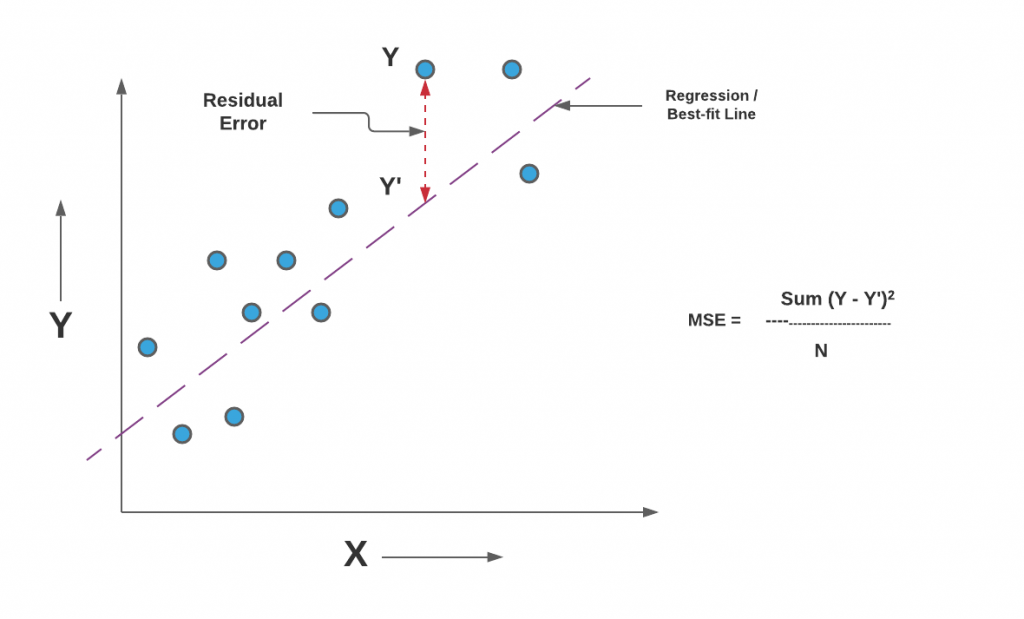

### Alright, now that all of that is out of the way lets dive in and try and build some models!



## **Import stuff**

In [2]:
%pip install seaborn
%pip install statsmodels


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Same data preparation code as in the other two notebooks. You can skip this- we are just applying the same cleaning and preprocessing we did before in this notebook to get the data in the cleaned state.

In [3]:
df = pd.read_csv('heart_disease.csv')

df.dropna(inplace=True)

categorical_columns = ['Gender', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'Heart_stroke']

for column in categorical_columns:
    df[column] = df[column].astype('category')
        
text_columns = ['Gender', 'education', 'prevalentStroke', 'Heart_stroke']

for column in text_columns: 
    df[column] = df[column].str.lower()
    
df['prevalentStroke'] = df['prevalentStroke'].map({'yes': 1, 'no': 0})
df['Heart_stroke'] = df['Heart_stroke'].map({'yes': 1, 'no': 0})
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})
df['education'] = df['education'].map({'uneducated': 0, 'primaryschool': 1, 'graduate':2, 'postgraduate':3})

###  Lets first remake our pair plot (on a smaller subset of the data) to take a look at some of the relationships between our variables

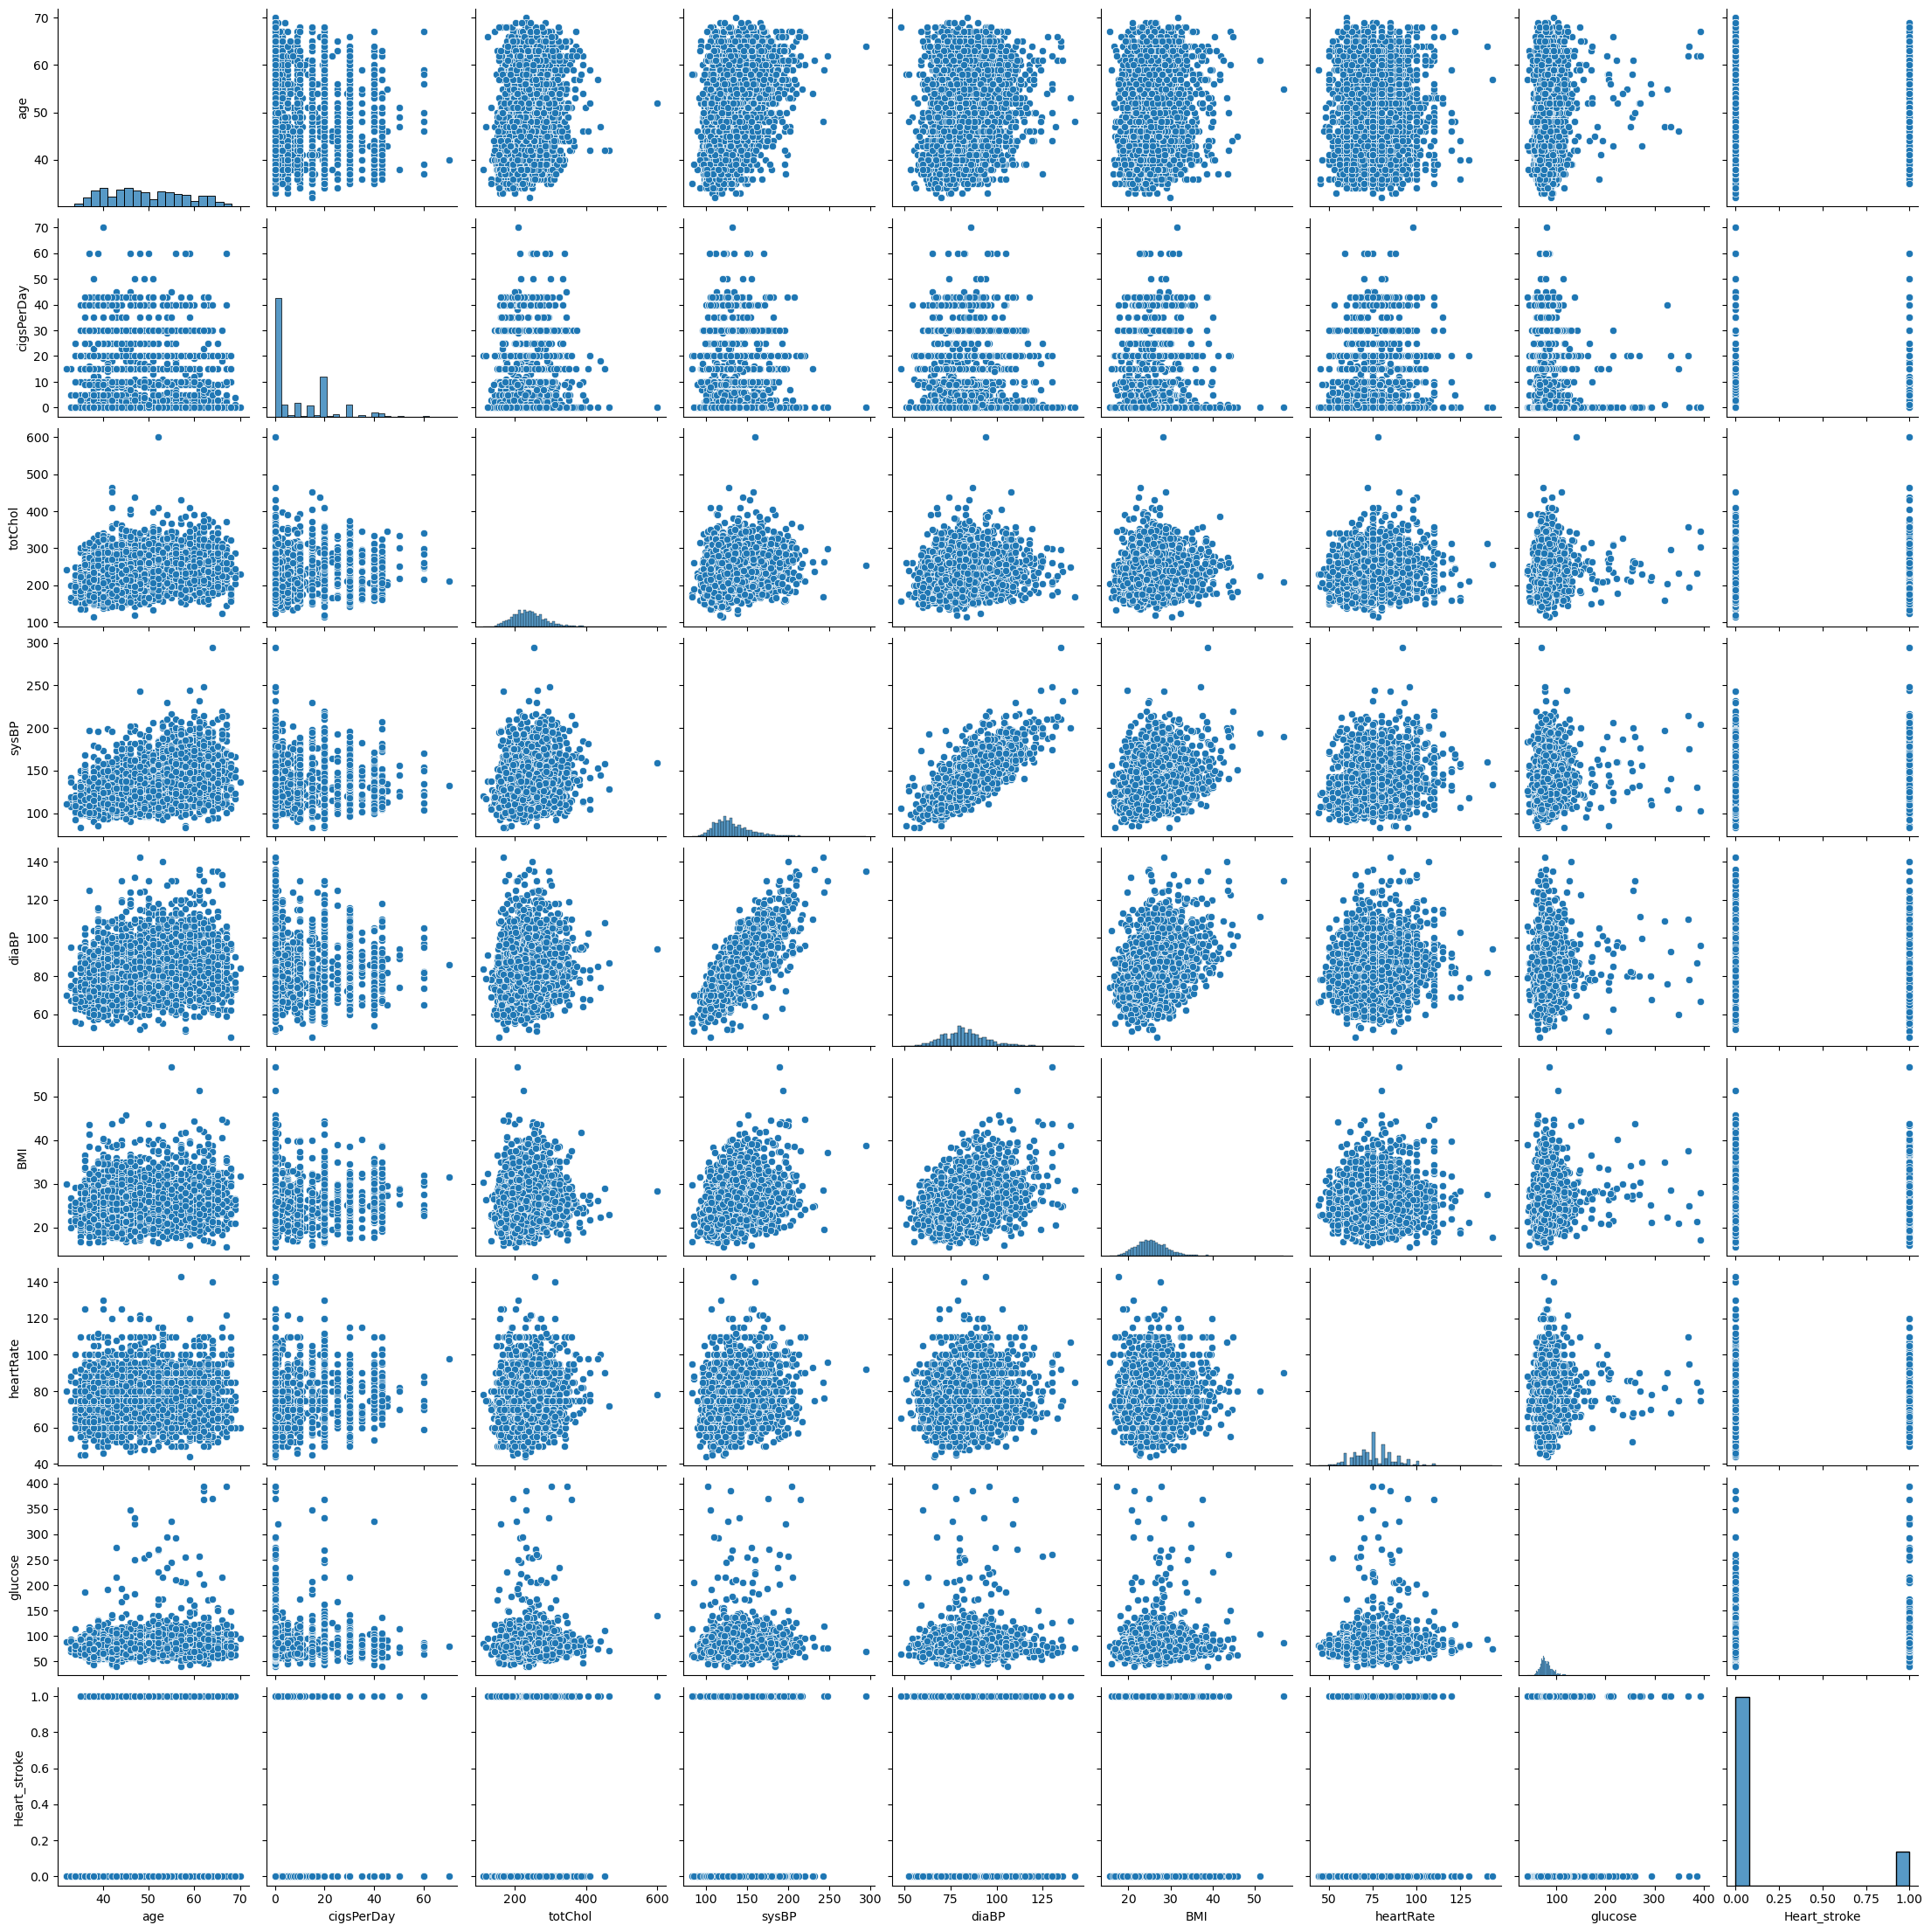

In [4]:
# Create a subset of the dataframe. 
# We do this by passing a list of these column names to the dataframe df. 
subset = df[['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'Heart_stroke']]

# create a "pair plot" of this subset. Pair plots are a great way to visualize relationships 
# between different pairings of these variables. In a pair plot, the diagonal elements show the histogram of the 
# data for that particular variable, and the off-diagonal elements show scatter plots of one variable versus another
sns.pairplot(subset)

# lets take a look!
plt.show()


### When doing real data science it is important to choose a model that makes sense with your data. Most of this data does not appear to be linear, but lets pick two examples that we will try and build models for.

### We do have one relationship that looks pretty linear: systolic and diastolic blood pressure (this also makes sense that it might be linear!). We will definitely try a linear regression for these data.

### Age and cholesterol also look to have *somewhat* of a linear relationship, so we will try to do a regression for that as well. Again, in the real world you probably would not do this, but here it will be good for practice!

## **Helper Functions**

### First, lets make some helper functions to speed up visualization and assessment of our models. We will see their implementation later on

In [5]:
# xTest: The independent test data.
# yTest: The actual values of the dependent test data.
# y_pred: The predicted values of the dependent test data generated by your model.
# title: A string that represents the title of the graph.
# xLabel: A string that represents the label of the x-axis.
# yLabel: A string that represents the label of the y-axis.
def visualize(xTest, yTest, y_pred, title, xLabel, yLabel):
    plt.scatter(xTest, yTest, color='blue', label='Actual')  # Scatter plot for actual values
    plt.scatter(xTest, y_pred, color='red', label='Predicted')  # Scatter plot for predicted values

    plt.legend() #add a legend

    plt.title(title)  # Set the title of the plot
    plt.xlabel(xLabel)  # Set the label for the x-axis
    plt.ylabel(yLabel)  # Set the label for the y-axis

    # Display the plot

    plt.show()


In [6]:
# y_pred: The predicted values generated by the model.
# y_test: The actual values of the dependent test data.
def assess(y_pred, y_test):
    # The Mean Squared Error (MSE) is a measure of how close a fitted line is to actual data points.
    # The smaller the Mean Squared Error, the closer the fit is to the data. 
    # The MSE is the average squared difference between the predicted and actual values.
    mse =  mean_squared_error(y_test, y_pred) # we import this method from scikitlearn earlier

    # The Coefficient of Determination
    # If the R2 of a model is 1, it means the dependent variable can be predicted without any error using the independent variable(s). 
    # An R2 of 0 indicates that the dependent variable cannot be predicted from the independent variable.
    r2 = r2_score(y_test, y_pred) # we import this method from scikitlearn earlier 
    
    # Return the Mean Squared Error and the Coefficient of Determination.
    return mse, r2


## **Age vs Total Cholesterol** 

### First we will split our training and testing data. This is SO important and has to be done correctly, otherwise you have no way to assess the performance of your model (we will see an example of testing data in the training set in module 5). Fortunately, `sklearn` has a built in `train_test_split` method which we imported earlier. An 80/20 train test split is common practice so we will use that in all the examples here

In [7]:
# Set the predictor (independent variable, 'X') as 'age' and the outcome (dependent variable, 'y') as 'totChol' from the dataframe.
X = df[['age']]  # predictor
y = df['totChol']  # outcome

# Split the dataset into training and testing sets using the train_test_split() function from sklearn's model_selection module. 
# We're using 80% of the data for training and 20% for testing. This is a very common split, but other splits are possible! 
# It is VERY VERY VERY important to make sure you split your data correctly. Training data in testing data is the biggest no no EVER
# The 'random_state' parameter ensures reproducibility of your split each time you run your code.
X_train_age, X_test_age, y_train_chol, y_test_chol = train_test_split(X, y, test_size=0.2, random_state=42)


### Now that we have split our data, lets initialize the model we want to use. Because we are doing linear regressions we will use the `LinearRegression()` method from `sklearn` which we imported earlier. Once we initialize we can fit the model using our training data

In [8]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train_age, y_train_chol)

# Print the y-intercept and the coefficients (slope) of the linear regression model.
# The y-intercept represents the predicted value of 'y' when 'X' is zero. Think y=mx+b
# The coefficients represent the change in the dependent variable resulting from a one unit change in the predictor.
print('Intercept:', model.intercept_)


Intercept: 171.98238037590693


### The intercept is not really important for us moving forward, but we included it just to remind you that the fitted model is really just a $y$ = $mx$ + $b$ equation, just like from high school math class. The coefficient is the $b$!

### What we just accomplished was fitting a model with our training data. Now we have a fitted linear model. This is nice, but means nothing until we evaluate it. We do this by making predictions with our X test data (`X_test_age`). Remember this was 20% of the original data, but it IS NOT in the train data!
### We can then visualize and assess the accuracy of our model using our helper functions we made earlier. Refer back to them if you are confused about the arguements being passed!

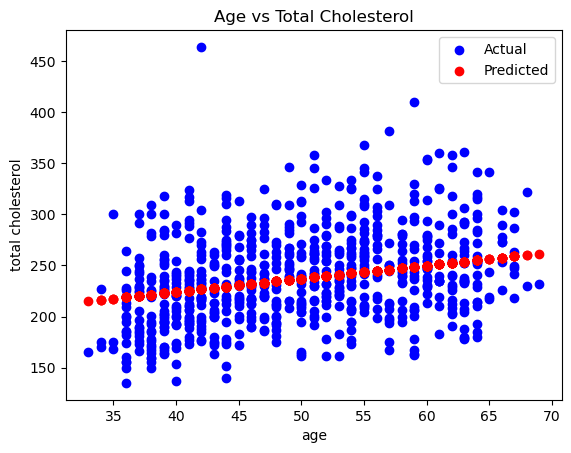

Intercept: 171.98238037590693
Coefficients (slope): [1.29935636]
mse: 1816.8332449662719
r2: 0.09792927613480207


In [9]:
# Use the fitted model to make predictions on the test data
y_pred_chol = model.predict(X_test_age)

# Visualize the actual and predicted values with a scatter plot
visualize(X_test_age, y_test_chol, y_pred_chol, 'Age vs Total Cholesterol', 'age', 'total cholesterol')

# Use the analyze function to calculate Mean Squared Error (MSE) and R2 score. 
# The Mean Squared Error (MSE) is a measure of how close a fitted line is to actual data points.
# The Coefficient of Determination, often denoted R2, is a statistical measure that represents 
# the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. 
mse_age_cholesterol, r2_age_cholesterol = assess(y_pred_chol, y_test_chol)

# Print out the model intercept, coefficient (slope), mean squared error (MSE), and R2 score
print('Intercept:', model.intercept_)
print('Coefficients (slope):', model.coef_)
print('mse:', mse_age_cholesterol)
print('r2:',r2_age_cholesterol)

### You have done it! Your first linear regression has been built. Now lets decide if it was a good one or not...

### First lets talk aobut the intercept and coeffiecient. These are the values the model converged to when finding the regression line. We can use these to represent the regression line (line of best fit) via  $\hat{Y}$ = 1.3 $x$ + 172.0 where $\hat{Y}$ is the predicted $y$ for a given $x$. Thats it! Thats the model!

### So was it good? Thats another story. We have a very high mean squared error, which means that the actual data is very far away from the line of best fit and we have a high residual error. Remember this chart? 
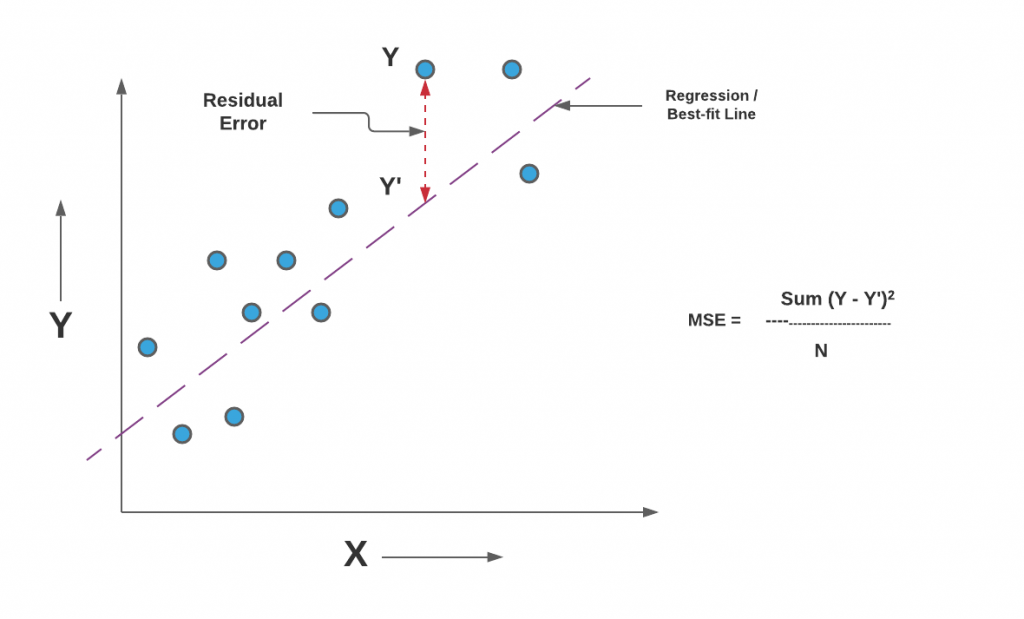
### We also have a very low r^2 value, which indicates the line of best fit does not match the data all that closely.

### However, this is to be expected. This model is trying to predict a person's cholesterol level from their age, which I think we can all agree is nonsense. So in light of that our model actually makes a good amount of sense.

### Lets try to build a model now that actually might have some value!

## **Systolic vs Diastolic BP**

### Try again with blood pressure measurements. Based on medical knowledge and the pair plot from earlier we expect to see a good linear relationship here... Lets check! This code is mostly the same as before, but still follow along and make sure you are understanding where the train and test data is going and why it is where it is

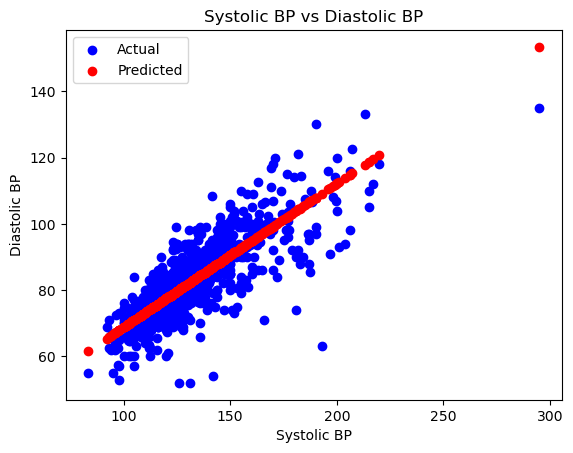

Intercept: 25.439970069863676
Coefficients (slope): [0.43371428]
mse: 58.5657202918078
r2: 0.6014684314244194


In [10]:
# Initialize the Linear Regression model
model = LinearRegression()

X = df[['sysBP']]   # define the column of the dataframe of the predictor
y = df['diaBP']   # define the column of the dataframe of the outcome of interest

X_train_sys, X_test_sys, y_train_dia, y_test_dia = train_test_split(X, y, test_size=0.2, random_state=42)  # split data into training and test

model.fit(X_train_sys, y_train_dia)  # Fit the linear regression model (defined above) with the training data 

y_pred_dia = model.predict(X_test_sys)  # make predictions on the test data and store the outcome in a new variable using the trained model

visualize(X_test_sys, y_test_dia, y_pred_dia, 'Systolic BP vs Diastolic BP', 'Systolic BP', 'Diastolic BP') # send data to the visualize function to graph

mse_sys_dias, r2_sys_dia = assess(y_pred_dia, y_test_dia) # analyze the predictions by computing MSE and R2

# Print the results
print('Intercept:', model.intercept_)
print('Coefficients (slope):', model.coef_)
print('mse:', mse_sys_dias)
print('r2:',r2_sys_dia)


### Now this one looks better. Our MSE is much lower, and our r^2 is .6 which is notably better. It is not a perfect model (r^2 would equal 1 and mse would be 0 in that case), but there is no such thing as a perfect model! Overall, this model is a decent linear regression and is a good use of learning from our data to make predictions.

### However, what we want to do now is start to make predictions from all (or some) of our data about whether or not someone will go on to develop a heart stroke. To do that, we need a different type of model- a logistic regression. Onwards and upwards!
